# Importing Libraries

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Importing Deep Learning Libraries
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix


In [78]:
picture_size = 48

# Making Training and Validation Data

In [79]:
batch_size  = 64

my_models = {}


datagen_train  = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,         
            width_shift_range=0.2,     
            height_shift_range=0.2,    
            shear_range=0.2,           
            zoom_range=0.2,            
            horizontal_flip=True,      
            fill_mode='nearest'
            )
datagen_val = ImageDataGenerator(rescale=1./255,  validation_split=0.5)

train_set = datagen_train.flow_from_directory("../input/train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


val_set = datagen_val.flow_from_directory("../input/validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=False)
set_set = datagen_val.flow_from_directory("../input/validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 3535 images belonging to 7 classes.
Found 3531 images belonging to 7 classes.


In [89]:
model_rmse = {}

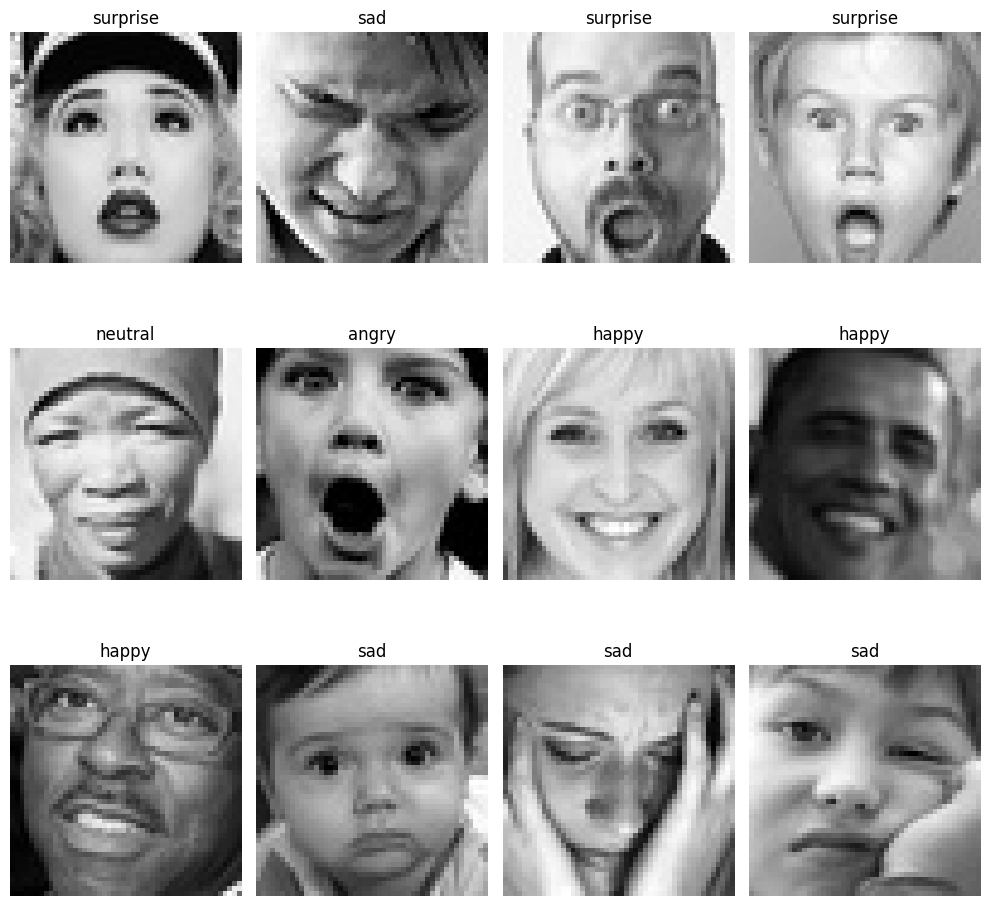

In [80]:
class_names = list(train_set.class_indices.keys())

# Configurar la visualización
plt.figure(figsize=(10, 10))

# Tomar un batch de imágenes y etiquetas
image_batch, label_batch = next(train_set)  # Obtén el siguiente batch

for i in range(12):  # Mostrar 12 imágenes
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i].reshape(picture_size, picture_size), cmap='gray')  # Muestra la imagen

    # Convierte el vector one-hot a un índice para acceder al nombre de la clase
    label_index = np.argmax(label_batch[i])  # Encuentra el índice de la etiqueta
    plt.title(class_names[label_index])  # Muestra el nombre de la clase

    plt.axis("off")  # Oculta los ejes

plt.tight_layout()
plt.show()

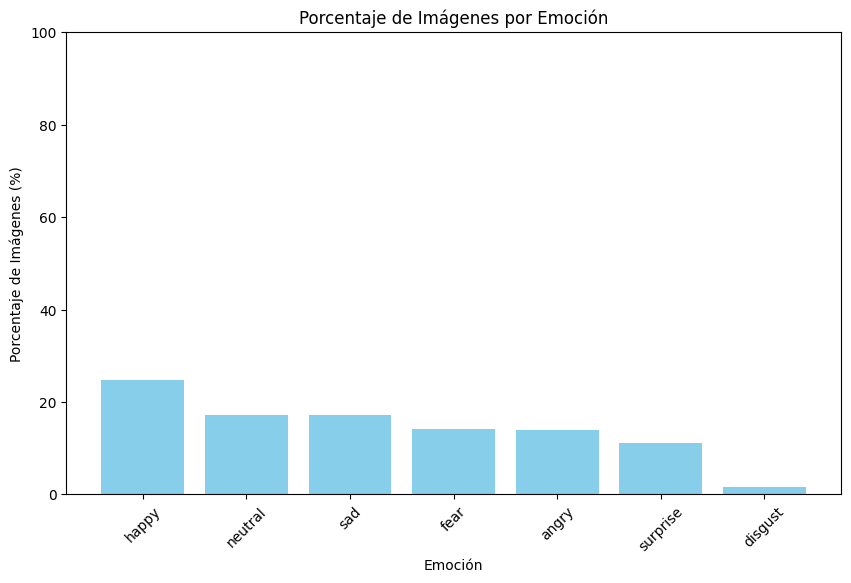

In [81]:
# Contar el número total de imágenes por etiqueta
class_indices = train_set.class_indices
class_labels = list(class_indices.keys())

# Contar imágenes en el directorio
image_counts = {label: 0 for label in class_labels}

for i in range(len(train_set.classes)):
    label = class_labels[train_set.classes[i]]
    image_counts[label] += 1

# Calcular el total de imágenes
total_images = sum(image_counts.values())

# Calcular porcentajes
image_percentages = {label: (count / total_images) * 100 for label, count in image_counts.items()}

# Crear un DataFrame para facilitar la visualización
df_counts = pd.DataFrame({
    'Emotion': list(image_percentages.keys()),
    'Percentage': list(image_percentages.values())
})

# Ordenar el DataFrame por porcentaje
df_counts = df_counts.sort_values(by='Percentage', ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df_counts['Emotion'], df_counts['Percentage'], color='skyblue')
plt.xlabel('Emoción')
plt.ylabel('Porcentaje de Imágenes (%)')
plt.title('Porcentaje de Imágenes por Emoción')
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Los porcentajes están en el rango [0, 100]
plt.show()

# Model Building

In [82]:
no_of_classes = 7

model_aux = models.Sequential([
    # 1ª Capa CNN
    layers.Conv2D(64, (3, 3), padding='same', input_shape=(picture_size, picture_size, 1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # 2ª Capa CNN
    layers.Conv2D(128, (5, 5), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # 3ª Capa CNN
    layers.Conv2D(512, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # 4ª Capa CNN
    layers.Conv2D(512, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # Aplanamiento de la salida de la última capa CNN
    layers.Flatten(),
    
    # Capa totalmente conectada (Dense) 1
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.25),
    
    # Capa totalmente conectada (Dense) 2
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.25),
    
    # Capa de salida
    layers.Dense(no_of_classes , activation='softmax')
])
opt = Adam(learning_rate=0.0001)
model_aux.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_aux.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 256)            │         1,02

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

# Fitting the Model with Training and Validation Data

In [83]:

# Configurar el checkpoint para guardar el mejor modelo
checkpoint_cnn = ModelCheckpoint("../models/cnn.keras",
                              monitor='val_accuracy', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')
checkpoint_leNet = ModelCheckpoint("../models/lenet.keras", 
                                     monitor='val_accuracy', 
                                     verbose=1, 
                                     save_best_only=True, 
                                     mode='max')
checkpoint_alexNet = ModelCheckpoint("../models/alexnet.keras", 
                                     monitor='val_accuracy', 
                                     verbose=1, 
                                     save_best_only=True, 
                                     mode='max')
checkpoint_efficientnetb0 = ModelCheckpoint("../models/efficientNet.keras", 
                                     monitor='val_accuracy', 
                                     verbose=1, 
                                     save_best_only=True, 
                                     mode='max')

# Configurar el early stopping
early_stopping_cnn = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=3,
                               verbose=1,
                               restore_best_weights=True)
early_stopping = EarlyStopping(
                       monitor='val_loss', 
                       min_delta=0,
                       patience=5,          
                       restore_best_weights=True  
)

# Configurar la reducción de la tasa de aprendizaje
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001)

# Lista de callbacks
callbacks_list_cnn= [early_stopping_cnn,reduce_learningrate ,checkpoint_cnn ]
callbacks_list_leNet= [early_stopping,reduce_learningrate,checkpoint_leNet]
callbacks_list_alexNet= [early_stopping,reduce_learningrate,checkpoint_alexNet]
callbacks_list_efficientnetb0= [early_stopping_cnn,reduce_learningrate,checkpoint_efficientnetb0]


# Compilar el modelo
model_aux.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),  # Actualizar lr a learning_rate
                  metrics=['accuracy'])

# Número de épocas
epochs = 48

In [84]:
total_images = train_set.samples
steps_per_epoch = total_images // batch_size
validedatio_images = val_set.samples 
validation_steps = validedatio_images // batch_size

In [85]:
history = model_aux.fit(
    train_set,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data= val_set,
    validation_steps=validation_steps,
    callbacks=callbacks_list_cnn
)

Epoch 1/48
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2779 - loss: 1.8978
Epoch 1: val_accuracy improved from -inf to 0.33636, saving model to ../models/cnn.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 529s 1s/step - accuracy: 0.2781 - loss: 1.8975 - val_accuracy: 0.3364 - val_loss: 1.7194 - learning_rate: 0.0010
Epoch 2/48
  1/450 ━━━━━━━━━━━━━━━━━━━━ 7:10 959ms/step - accuracy: 0.4531 - loss: 1.3860
Epoch 2: val_accuracy did not improve from 0.33636
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 441us/step - accuracy: 0.4531 - loss: 1.3860 - val_accuracy: 0.0000e+00 - val_loss: 3.3081 - learning_rate: 0.0010
Epoch 3/48
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4477 - loss: 1.4282
Epoch 3: val_accuracy improved from 0.33636 to 0.49176, saving model to ../models/cnn.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 534s 1s/step - accuracy: 0.4477 - loss: 1.4281 - val_accuracy: 0.4918 - val_loss: 1.3233 - learning_rate: 0.0010
Epoch 4/48
  1/450 ━━━━━━━━━━━━━━━━━━━━ 6:54 924ms/step - accuracy: 0.6250 - 

In [90]:
my_models["cnn"]=history
model_rmse["cnn"]=model_aux

# LeNet-5

In [91]:
model_lenet_5 = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(picture_size, picture_size, 1)),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(filters=48, kernel_size=(5, 5), padding='valid', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(84, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(no_of_classes, activation='softmax')  # Capa de salida para 10 clases
])

In [92]:
model_lenet_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_lenet_5.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 48, 48, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 20, 20, 48)     │        38,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 10, 10, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 4800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │     1,229,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 84)             │        21,588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 7)              │           595 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,290,519 (4.92 MB)

 Trainable params: 1,290,519 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
history_lenet_5= model_lenet_5.fit(train_set, validation_data= val_set, epochs=30, batch_size=32, callbacks=[callbacks_list_leNet] )

Epoch 1/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2423 - loss: 1.8334
Epoch 1: val_accuracy improved from -inf to 0.38727, saving model to ../models/lenet.keras
451/451 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.2424 - loss: 1.8332 - val_accuracy: 0.3873 - val_loss: 1.6054 - learning_rate: 0.0010
Epoch 2/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3631 - loss: 1.6195
Epoch 2: val_accuracy improved from 0.38727 to 0.43281, saving model to ../models/lenet.keras
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.3632 - loss: 1.6195 - val_accuracy: 0.4328 - val_loss: 1.4727 - learning_rate: 0.0010
Epoch 3/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4212 - loss: 1.5080
Epoch 3: val_accuracy improved from 0.43281 to 0.45771, saving model to ../models/lenet.keras
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.4212 - loss: 1.5080 - val_accuracy: 0.4577 - val_loss: 1.4096 - learning_rate: 0.0010
Epoch 4/30
451/451 ━━━━━━━━━━━━

In [94]:
my_models["lenet_5"]=history_lenet_5
model_rmse["lenet_5"]=model_lenet_5

# AlexNet

In [95]:
model_alexnet = models.Sequential([
    layers.Conv2D(96, kernel_size=(7, 7), strides=2, activation='relu', padding='valid', input_shape=(picture_size, picture_size, 1)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

    layers.Conv2D(256, kernel_size=(5, 5), strides=1, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

    layers.Conv2D(384, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    layers.Conv2D(384, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    layers.Conv2D(256, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    
    layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),
    
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(no_of_classes, activation='softmax')  
])

In [96]:
model_alexnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_alexnet.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 21, 21, 96)     │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 10, 10, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 10, 10, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 4, 4, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 7)              │        28,679 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,579,719 (82.32 MB)

 Trainable params: 21,579,719 (82.32 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
history_alexnet= model_alexnet.fit(train_set, validation_data= val_set, epochs=30, batch_size=32, callbacks=[callbacks_list_alexNet] )

Epoch 1/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.2455 - loss: 1.8231
Epoch 1: val_accuracy improved from -inf to 0.25827, saving model to ../models/alexnet.keras
451/451 ━━━━━━━━━━━━━━━━━━━━ 261s 575ms/step - accuracy: 0.2455 - loss: 1.8231 - val_accuracy: 0.2583 - val_loss: 1.8147 - learning_rate: 0.0010
Epoch 2/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.2473 - loss: 1.8124
Epoch 2: val_accuracy did not improve from 0.25827
451/451 ━━━━━━━━━━━━━━━━━━━━ 284s 629ms/step - accuracy: 0.2473 - loss: 1.8124 - val_accuracy: 0.2583 - val_loss: 1.8094 - learning_rate: 0.0010
Epoch 3/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.2481 - loss: 1.8116
Epoch 3: val_accuracy did not improve from 0.25827
451/451 ━━━━━━━━━━━━━━━━━━━━ 286s 634ms/step - accuracy: 0.2481 - loss: 1.8116 - val_accuracy: 0.2583 - val_loss: 1.8136 - learning_rate: 0.0010
Epoch 4/30
 15/451 ━━━━━━━━━━━━━━━━━━━━ 3:51 532ms/step - accuracy: 0.2350 - loss: 1.8269

In [ ]:
my_models["alexnet"]=history_alexnet
model_rmse["alexnet"]=model_alexnet

# Analyse Convergence

In [ ]:
def plot_loss_for_models(history_dict):
    # Verificar si history_dict es un diccionario
    if not isinstance(history_dict, dict):
        raise TypeError("El argumento history_dict debe ser un diccionario con los nombres de los modelos como claves y los objetos History como valores.")

    for model_name, history in history_dict.items():
        # Verificar si el valor en el diccionario es un objeto History
        if not hasattr(history, 'history'):
            raise TypeError(f"El valor asociado a {model_name} no es un objeto History válido.")

        # Obtener loss y val_loss
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(loss) + 1)

        # Crear el gráfico
        plt.figure()
        plt.plot(epochs, loss, 'bo', label='Training Loss')
        plt.plot(epochs, val_loss, 'b', label='Validation Loss')
        plt.title(f'Value of the Loss Function for {model_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Value of the Loss Function')
        plt.legend()
        plt.grid(True)
        plt.show()

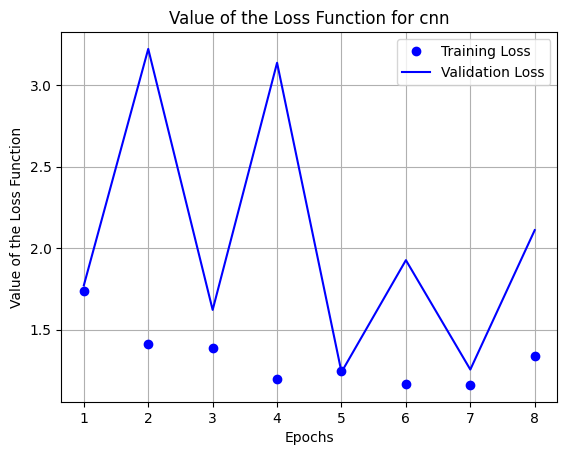

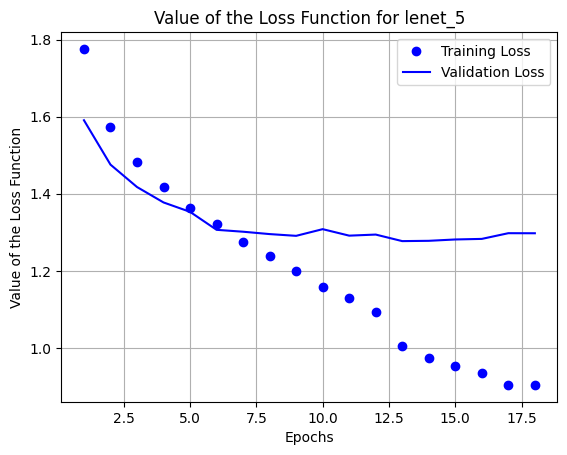

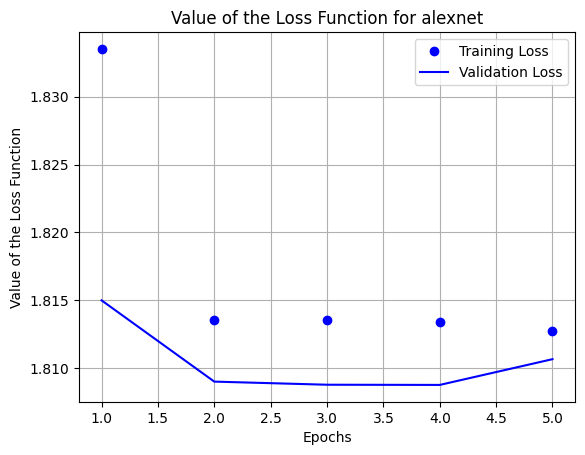

In [ ]:
plot_loss_for_models(my_models)

In [ ]:
def plot_accuracy_for_models(history_dict):
    for model_name, history in history_dict.items():
        # Obtener accuracy y val_accuracy
        acc = history.history['accuracy']
        acc_val = history.history['val_accuracy']
        epochs = range(1, len(acc) + 1)

        # Crear el gráfico
        plt.figure()
        plt.plot(epochs, acc, 'bo', label='Training Accuracy')
        plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
        plt.title(f'Accuracy for {model_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Value of Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

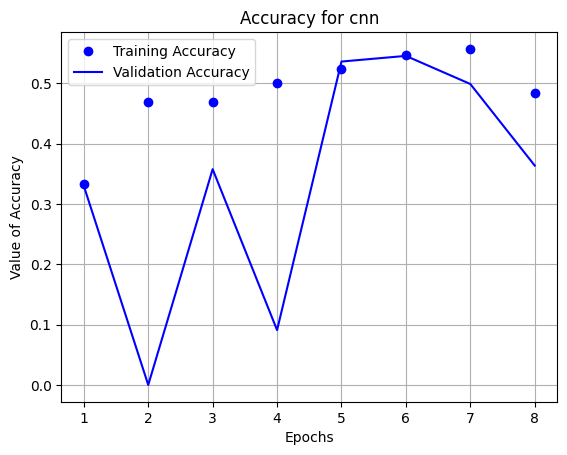

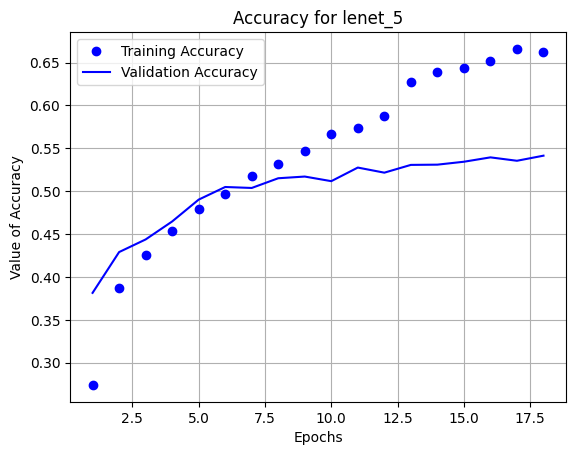

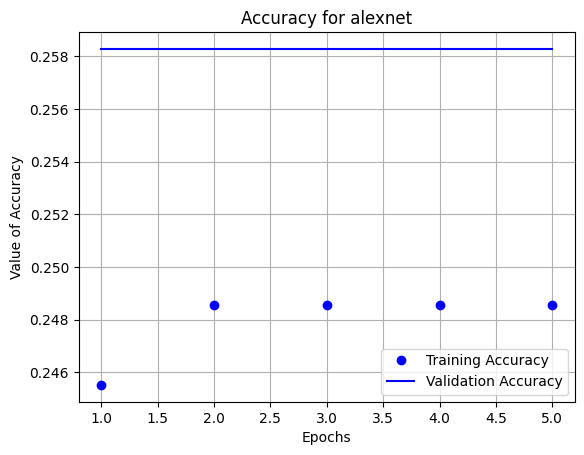

In [ ]:
plot_accuracy_for_models(my_models)

# Analyse Results

In [ ]:
import matplotlib.pyplot as plt

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, index):
    # Asegúrate de que el índice está dentro del rango
    if index >= len(test_image_array) or index < 0:
        raise ValueError("Índice fuera de rango")

    # Obtener la imagen y la etiqueta correspondiente
    image = test_image_array[index]
    true_label = test_image_label[index]
    predictions = pred_test_labels[index]

    # Etiquetas de las emociones (asegúrate de que estas etiquetas coinciden con el índice de predicciones)
    emotion_labels = ['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Anger', 'Disgust', 'Fear']  # Ejemplo

    # Configurar la figura con dos subgráficas (imagen y gráfico de barras)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Mostrar la imagen
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title(f'Imagen: {true_label}')
    ax[0].axis('off')  # No mostrar los ejes

    # Mostrar el gráfico de barras
    ax[1].bar(emotion_labels, predictions, color='blue')
    ax[1].set_title('Predicciones de Emoción')
    ax[1].set_xlabel('Emoción')
    ax[1].set_ylabel('Probabilidad')

    plt.tight_layout()
    plt.show()

56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step


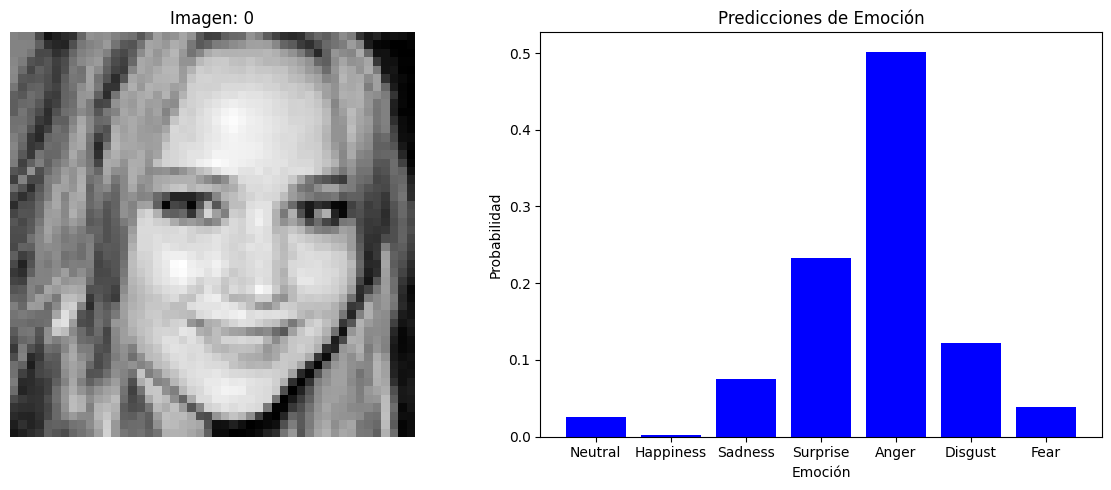

In [ ]:
url = "../models/cnn.keras"
model_aux = load_model(url) 
# Paso 2: Hacer predicciones con el modelo
predictions = model_aux.predict(set_set)
# Paso 3: Extraer las imágenes y etiquetas del generador de datos
test_image_array = np.array([set_set[i][0][0] for i in range(len(set_set))])
test_image_label = [set_set.classes[i] for i in range(len(set_set))]

# Normalizar las predicciones
pred_test_labels = predictions  # Ya están en la escala correcta

# Paso 4: Llamar al método para mostrar la imagen y las predicciones
# Nota: Asegúrate de que el índice 106 esté dentro del rango de datos disponibles
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 20)

# Analyse Wrong Prediction

In [ ]:
all_images = []
all_labels = []

# Iterar a través del generador hasta que no haya más datos
for batch in set_set:
    images, labels = batch
    all_images.append(images)
    all_labels.append(labels)
    
    # Si el generador está agotado, salir del bucle
    if set_set.batch_index >= len(set_set) - 1:
        break

# Convertir las listas a arrays numpy
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

len(all_labels)


3531

In [ ]:
len(predictions)

3531

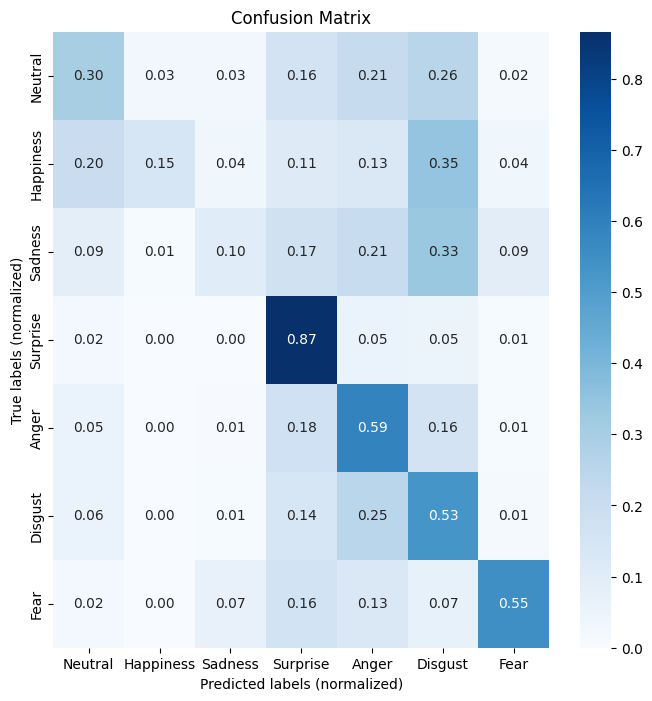

In [ ]:
def create_comparison_dataframe(predictions, test_labels):
   
    # Convertir predicciones y etiquetas en índices de clases
    pred_test_labels = predictions.argmax(axis=1)
    true_labels = test_labels.argmax(axis=1)

    # Crear DataFrame de comparación
    df_compare = pd.DataFrame()
    df_compare['real'] = true_labels
    df_compare['pred'] = pred_test_labels
    df_compare['wrong'] = np.where(df_compare['real'] != df_compare['pred'], 1, 0)

    return df_compare

def plot_confusion_matrix(conf_mat, show_normed=True, show_absolute=True, class_names=None, figsize=(8, 8)):
   
    fig, ax = plt.subplots(figsize=figsize)

    # Normalizar los valores de la matriz de confusión si es necesario
    if show_normed:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(conf_mat, annot=True, fmt='.2f' if show_normed else 'd', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax)

    if show_absolute:
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
    else:
        ax.set_xlabel('Predicted labels (normalized)')
        ax.set_ylabel('True labels (normalized)')
        
    ax.set_title('Confusion Matrix')
    plt.show()
    
    return fig, ax

#
df_compare = create_comparison_dataframe(predictions, all_labels)

# Calcular la matriz de confusión
conf_mat = confusion_matrix(all_labels.argmax(axis=1), predictions.argmax(axis=1))

# Asumiendo que tienes un diccionario de emociones como `emotions` con nombres de clases
emotions = {0: 'Neutral', 1: 'Happiness', 2: 'Sadness', 3: 'Surprise', 4: 'Anger', 5: 'Disgust', 6: 'Fear'}

# Visualizar la matriz de confusión
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=list(emotions.values()),
                                figsize=(8, 8))

In [ ]:
# Ruta al archivo del modelo guardado
model_path = "../models/model.keras"

# Carga el modelo
model = load_model(model_path)

# Supongamos que ya has definido tu conjunto de datos de validación como `set_set`
# Evaluar el modelo en el conjunto de datos de validación
loss, accuracy = model.evaluate(set_set, verbose=1)

print(f'Precisión en el conjunto de validación: {accuracy:.4f}')
print(f'Pérdida en el conjunto de validación: {loss:.4f}')

c:\Users\gentl\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3377 - loss: 1.7297
Precisión en el conjunto de validación: 0.4840
Pérdida en el conjunto de validación: 1.3945


In [ ]:
def calculate_rmse_for_models(models_dict, datagen_val):
    """
    Calcula el RMSE para cada modelo en un diccionario utilizando un generador de imágenes.

    Parámetros:
    - models_dict: dict, un diccionario donde las claves son nombres de modelos y los valores son los modelos entrenados.
    - datagen_val: generador de imágenes que produce lotes de imágenes y etiquetas.

    Retorna:
    - rmse_dict: dict, un diccionario donde las claves son nombres de modelos y los valores son los RMSE correspondientes.
    """
    rmse_dict = {}

    for model_name, model in models_dict.items():
        # Inicializar listas para almacenar las etiquetas verdaderas y las predicciones
        all_true_labels = []
        all_pred_labels = []

        # Iterar sobre los datos del generador
        for batch_images, batch_labels in datagen_val:
            # Realizar predicciones
            batch_preds = model.predict(batch_images)
            
            # Convertir las predicciones y etiquetas a formato de clase si es necesario
            if batch_labels.ndim > 1 and batch_labels.shape[1] > 1:
                batch_true_labels = batch_labels.argmax(axis=1)
                batch_pred_labels = batch_preds.argmax(axis=1)
            else:
                batch_true_labels = batch_labels
                batch_pred_labels = batch_preds

            # Acumular las etiquetas verdaderas y predicciones
            all_true_labels.extend(batch_true_labels)
            all_pred_labels.extend(batch_pred_labels)

            # Detener la iteración si hemos recorrido todas las batches
            if len(all_true_labels) >= datagen_val.samples:
                break

        # Convertir listas a arrays
        all_true_labels = np.array(all_true_labels)
        all_pred_labels = np.array(all_pred_labels)

        # Calcular el RMSE
        rmse = np.sqrt(mean_squared_error(all_true_labels, all_pred_labels))

        # Guardar el RMSE en el diccionario
        rmse_dict[model_name] = rmse

    return rmse_dict

# Uso del método
rmse_results = calculate_rmse_for_models(my_models, set_set)

# Imprimir los resultados
for model_name, rmse in rmse_results.items():
    print(f"RMSE for {model_name}: {rmse}")